## Position Estimation Based on LSTM With 20 Timesteps (2Sec) Before 

#### Import what we need 

In [1]:
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import os
import pickle
import keras
from keras.layers import *
from keras.models import *
# to produce some visualizations of our training

import IPython.display as ipyd
plt.style.use('ggplot')


Using TensorFlow backend.


## Create Our Dataset

In [3]:
#define 1D and 2D distance function
def distance2(p0,p1):
    
    return ((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def distance(p0,p1):
    
    return ((p0 - p1)**2)

###$$ GET_SPIKES_WITH_HISTORY with or without variable stride #####

def get_spikes_with_history_Stride1(neural_data,data,bins_before,bins_current=1):
    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with Na
    Y=np.zeros((num_examples,surrounding_bins,4))
    X[:] = 0
    start_idx=0
    for i in range(num_examples-bins_before): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i,:,:]=neural_data[start_idx:end_idx,:] #Put neural data from surrounding bins in X, starting at row "bins_before"
        Y[i,:,:]=data[start_idx:end_idx,:]
        start_idx=start_idx+1
    return [X,Y]

def get_spikes_with_history(neural_data,data,bins_before,strides,bins_current=1):
    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with NaNs
    X[:] = 0
    Y=np.zeros((num_examples,surrounding_bins,4))
    
    start_idx=0
    for i in range(num_examples): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i,:,:]=neural_data[start_idx:end_idx,:] #Put neural data from surrounding bins in X, starting at row "bins_before"
        Y[i,:,:]=data[start_idx:end_idx,:]
        start_idx=start_idx+np.int(strides[i]);
        if start_idx >= num_examples-bins_before-1:
            break
    return [X[:i],Y[:i]]

bins_before=19 #How many bins of neural data prior to the output are used for decoding
TS=bins_before+1 # Number of total timesteps that we will use in decoder model

# import data
path2='MS-100msec.mat'
mat=spio.loadmat(path2,squeeze_me=True)
x_data=mat['MSTrain'][:,1:63].astype('float32')
y_data=mat['MSTrain'][:,63:67].astype('float32')

# Calculate Min and max 
y_data2=np.zeros((y_data.shape))

yMinX=np.min(y_data[:,0],axis=0)
yMinY=np.min(y_data[:,1],axis=0)
yMaxX=np.max(y_data[:,0],axis=0)
yMaxY=np.max(y_data[:,1],axis=0)

VxMin=np.min(y_data[:,2],axis=0)
VyMin=np.min(y_data[:,3],axis=0)
VxMax=np.max(y_data[:,2],axis=0)
VyMax=np.max(y_data[:,3],axis=0)
NT=1377 ## Number Of Test
NTr=5500
#Generate for maze classification section

ArmInd=np.zeros((x_data.shape[0],4))
y=y_data
for i in range(x_data.shape[0]):
    if y[i,0] >= 165 and y[i,0] <= 200 and y[i,1] >= 60 and y[i,1] <= 165:
        ArmInd[i,1]=1
    elif y[i,0] > 200 and y[i,0] <= 240 and y[i,1] >= 60 and y[i,1] <= 165:
        ArmInd[i,2]=1
    elif y[i,0] > 240 and y[i,0] <= 265 and y[i,1] >= 60 and y[i,1] <= 165:
        ArmInd[i,3]=1
    else:
        ArmInd[i,4]=1

## Normalizing Data

y_data2[:y_data.shape[0]-NT,0]=np.divide(y_data[:y_data.shape[0]-NT,0]-yMinX,yMaxX-yMinX)
y_data2[:y_data.shape[0]-NT,1]=np.divide(y_data[:y_data.shape[0]-NT,1]-yMinY,yMaxY-yMinY)

y_data2[:y_data.shape[0]-NT,2]=np.divide(y_data[:y_data.shape[0]-NT,2]-VxMin,VxMax-VxMin)
y_data2[:y_data.shape[0]-NT,3]=np.divide(y_data[:y_data.shape[0]-NT,3]-VyMin,VyMax-VyMin)

### Create training and test data
[X_test,a]=get_spikes_with_history_Stride1(x_data[y_data.shape[0]-NT:],y_data2[y_data.shape[0]-NT:],bins_before)

[X_train,y_d]=get_spikes_with_history_Stride1(x_data[:NTr],y_data2[0:NTr],bins_before)

y_train=y_d[:NTr,0,:]

y_dd=np.concatenate([np.zeros((1,TS,4)),y_d[:NTr-1]])

y_test=y_data[y_data.shape[0]-NT:]
Arm_train=ArmInd[:NTr]
Arm_test=ArmInd[y_data.shape[0]-NT:]
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)




Train data shape:  (5500, 20, 62)
Train labels shape:  (5500, 4)
Test data shape:  (1377, 20, 62)
Test labels shape:  (1377, 4)


# Maze Classifier

In [4]:
#Create Maze classifier model
In=Input(shape=(TS,62),name='Input')
Mb=LSTM(4,return_sequences=True,name='MazeSeq')(In)
Ma=LSTM(4,activation='sigmoid',name='MazeClass')(Mb)
Mz=Model(inputs=In,outputs=Ma)
# Let's train the model using RMSprop
Mz.compile(loss={'MazeClass':'binary_crossentropy'},optimizer='rmsprop',metrics=['accuracy'])

# Create summary of model
Mz.summary()

# Training section
path='saved_models/MazeClass4.h5'
Mz.load_weights(path)
#Hist=Mz.fit(X_train,Arm_train,validation_data=(X_test,Arm_test),shuffle=True,epochs=5,verbose=1,batch_size=100)
Mz.save_weights(path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 20, 62)            0         
_________________________________________________________________
MazeSeq (LSTM)               (None, 20, 4)             1072      
_________________________________________________________________
MazeClass (LSTM)             (None, 4)                 144       
Total params: 1,216
Trainable params: 1,216
Non-trainable params: 0
_________________________________________________________________


# Velocity Estimator

In [5]:
#Create velocity estimator model
In=Input(shape=(TS,62),name='Input')
V1=LSTM(2,return_sequences=True,name='VelocitySeq')(In)
V=LSTM(2,activation='sigmoid',name='EstimatedVelocity')(V1)
Ve=Model(inputs=In,outputs=V)
# Let's train the model using RMSprop
Ve.compile(loss={'EstimatedVelocity':'mse'},optimizer='rmsprop')

# Create summery of model
Ve.summary()
# Training section
path='saved_models/VelocityEstimator4.h5'
Ve.load_weights(path)
#Hist=Ve.fit(X_train,y_train[:,2:],shuffle=True,epochs=20,verbose=1,batch_size=100)
Ve.save_weights(path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 20, 62)            0         
_________________________________________________________________
VelocitySeq (LSTM)           (None, 20, 2)             520       
_________________________________________________________________
EstimatedVelocity (LSTM)     (None, 2)                 40        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


### analyze outputs of velocity estimator

RMSE Estmation X=5.315792
RMSE Estmation Y=7.897498
2D Distance=9.519880


Text(0.5,1,'Estimate Velocity Y with RMSE=7.897498')

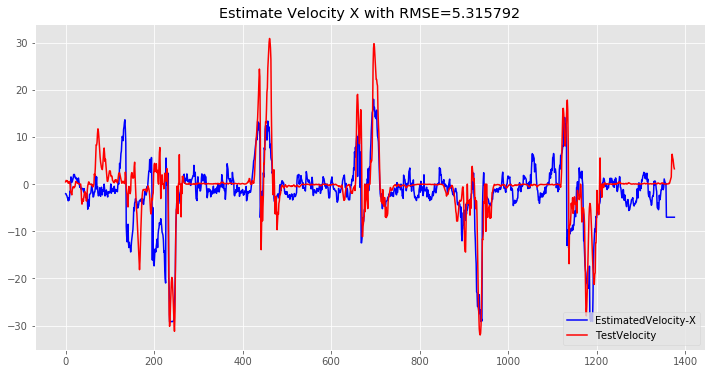

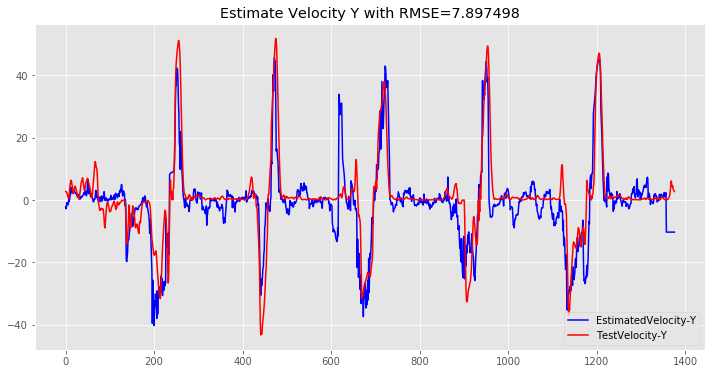

In [6]:
Velocity=Ve.predict(X_test)
Velocity[:,0]=np.multiply(Velocity[:,0],VxMax-VxMin)+VxMin
Velocity[:,1]=np.multiply(Velocity[:,1],VyMax-VyMin)+VyMin

### RMSE

rmsVX=np.zeros(y_test.shape[0])
rmsVY=np.zeros(y_test.shape[0])
aV=np.zeros(y_test.shape[0])
for i in range(0,y_test.shape[0]):
    rmsVX[i] = np.mean(distance(y_test[i,2], Velocity[i,0]))
    rmsVY[i] = np.mean(distance(y_test[i,3], Velocity[i,1]))
    aV[i]=distance2(y_test[i,2:], Velocity[i,:2])
rmsVX=np.sqrt(np.mean(rmsVX))
rmsVY=np.sqrt(np.mean(rmsVY))
b=np.sqrt(np.mean(aV))
print('RMSE Estmation X=%f'%rmsVX)

print('RMSE Estmation Y=%f'%rmsVY)
print('2D Distance=%f'%b)
### Plot Velocities X & Y
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(Velocity[:,0],'b',label="EstimatedVelocity-X")


plt.plot(y_test[:,2],'r',label="TestVelocity")

plt.legend(loc=4)
plt.title('Estimate Velocity X with RMSE=%f'%rmsVX)
#plt.savefig('EstimatedTestPath-Y.png',format='png', dpi=1000,transparent=False)
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(Velocity[:,1],'b',label="EstimatedVelocity-Y")


plt.plot(y_test[:,3],'r',label="TestVelocity-Y")

plt.legend(loc=4)
plt.title('Estimate Velocity Y with RMSE=%f'%rmsVY)
#plt.savefig('EstimatedTestPath-Y.png',format='png', dpi=1000,transparent=False)


# Position Estimator

Figure below shows The block diagram of LSTM based model
![](Block01.png)

We used previous estimated positions as penalization terms in training loss function (some kind of feedback, but, just for loss)

In [9]:
import keras.backend as K

# Define cost function for bouth positions
def penalized_lossY(FB,Pen,Maze):
    Pen1=(K.abs(Pen-.5))*2
    Pen2=(.5-K.abs(Pen-0.5))*2
    MI=K.argmax(Maze,axis=-1)
    def loss(y_true, y_pred):
        if MI == 4:
            return K.mean( K.square(y_pred - FB))
        else:
             return K.mean(K.square(y_pred - y_true)*Pen1 + K.square(y_pred - FB)*Pen2, axis=-1)
    return loss

def penalized_lossX(FB,Pen,Maze):
    Pen1=(K.abs(Pen-.5))*2
    Pen2=(.5-K.abs(Pen-0.5))*2
    MI=K.argmax(Maze,axis=-1)
    def loss(y_true, y_pred):
        if MI == 4 :
            return K.mean( K.square(y_pred - FB))
        else:
             return K.mean(K.square(y_pred - y_true)*Pen1 + K.square(y_pred - FB)*Pen2, axis=-1)
    return loss

# Create position estimator model
In=Input(shape=(TS,62),name='Input')
In2=Input(shape=(2,),name='FB')
V1=LSTM(2,return_sequences=True,name='VelocitySeq')(In)
Mb=LSTM(4,return_sequences=True,name='MazeSeq')(In)
V=LSTM(2,activation='sigmoid',name='EstimatedVelocity')(V1)
Pe=LSTM(4,return_sequences=True,name='PositionSeq')(In)
M=concatenate([V1,Pe,Mb],axis=-1,name='ConcatFeatures')
PYY=LSTM(1,name='firstStageOfY')(M)
Ma=LSTM(4,activation='sigmoid',name='MazeClass')(Mb)
PXX=LSTM(1,name='firstStageOfX')(M)
M2=concatenate([PXX,Ma],name='Concat_Maze_Class_With_X_Features')
M3=concatenate([PYY,Ma],name='Concat_Maze_Class_With_Y_Features')
PY=Dense(1,activation='sigmoid',name='EstimatedPositionY')(M3)
PX=Dense(1,activation='sigmoid',name='EstimatedPositionX')(M2)
model=Model(inputs=[In,In2],outputs=[PX,PY,V])
#Load pre-trained model weights
print(model.layers[1].get_weights()[0].shape)
print(Ve.layers[1].get_weights()[0].shape)

print(model.layers[12].get_weights()[0].shape)
print(Ve.layers[2].get_weights()[0].shape)

print(model.layers[3].get_weights()[0].shape)
print(Mz.layers[1].get_weights()[0].shape)

print(model.layers[6].get_weights()[0].shape)
print(Mz.layers[2].get_weights()[0].shape)


model.layers[1].trainable = False
model.layers[6].trainable = False
model.layers[12].trainable = False
model.layers[3].trainable = False

opt = keras.optimizers.rmsprop(lr=.001, decay=1e-6)
model.compile(loss={'EstimatedPositionX':penalized_lossX(FB=In2[:,0],Pen=V[:,0],Maze=Ma),
                    'EstimatedPositionY':penalized_lossY(FB=In2[:,1],Pen=V[:,1],Maze=Ma)},optimizer=opt)

model.layers[1].set_weights(Ve.layers[1].get_weights())
model.layers[12].set_weights(Ve.layers[2].get_weights())

model.layers[3].set_weights(Mz.layers[1].get_weights())
model.layers[6].set_weights(Mz.layers[2].get_weights())
model.summary()

# Training section
path='saved_models/PositionEstimator5.h5'
model.load_weights(path)
#Hist=model.fit([X_train,y_dd[:,0,:2]],[y_train[:,0],y_train[:,1]],shuffle=False,epochs=1,verbose=1,batch_size=25)
model.save_weights(path)

(62, 8)
(62, 8)
(2, 8)
(2, 8)
(62, 16)
(62, 16)
(4, 16)
(4, 16)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: Output "EstimatedVelocity" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "EstimatedVelocity" during training.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 20, 62)        0                                            
____________________________________________________________________________________________________
VelocitySeq (LSTM)               (None, 20, 2)         520         Input[0][0]                      
____________________________________________________________________________________________________
PositionSeq (LSTM)               (None, 20, 4)         1072        Input[0][0]                      
____________________________________________________________________________________________________
MazeSeq (LSTM)                   (None, 20, 4)         1072        Input[0][0]                      
___________________________________________________________________________________________

### Analyze position estimator outputs

In [ ]:
import timeit

start = timeit.default_timer()
#Get predictions
y_valid_predicted_lstm=np.zeros((y_test[:,:2].shape))
Vs=np.zeros((y_test[:,:2].shape))
y_predict=np.zeros((y_test[:,:2].shape))
FB=y_dd[-1,0,:2].reshape(1,2)
y_valid_predicted_lstm[0,:2]=FB

for i in range(TS,y_test.shape[0]):
    
    [y_valid_predicted_lstm[i,0],y_valid_predicted_lstm[i,1],Vs[i]]=model.predict([X_test[i].reshape(1,TS,62),FB.reshape(1,2)])
    FB=y_valid_predicted_lstm[i,:].reshape(1,2)

y_predict[:,0]=np.multiply(y_valid_predicted_lstm[:,0],yMaxX-yMinX)+yMinX
y_predict[:,1]=np.multiply(y_valid_predicted_lstm[:,1],yMaxY-yMinY)+yMinY


stop = timeit.default_timer()

print('test time=%f'% (stop - start) )
### calculate RMSE and 2d distance for X,Y Test path

rmsX=np.zeros(y_test.shape[0])
rmsY=np.zeros(y_test.shape[0])
a=np.zeros(y_test.shape[0])
for i in range(TS,y_test.shape[0]-TS):
    rmsX[i] = np.mean(distance(y_test[i,0], y_predict[i,0]))
    rmsY[i] = np.mean(distance(y_test[i,1], y_predict[i,1]))
    a[i]=distance2(y_test[i,:2], y_predict[i,:2])
rmsX=np.sqrt(np.mean(rmsX))
rmsY=np.sqrt(np.mean(rmsY))
b=np.sqrt(np.mean(a))
print('RMSE Estmation X=%f'%rmsX)

print('RMSE Estmation Y=%f'%rmsY)
print('2D Distance=%f'%b)
### plot and save predictions

plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predict[TS:-1-TS,1],'b',label="EstimatedTestPath-Y")


plt.plot(y_test[TS:-1-TS,1],'r',label="TestPath-Y")

plt.legend(loc=4)
plt.title('Estimate position Y with RMSE=%f'%rmsY)
#plt.savefig('EstimatedTestPath-Y.png',format='png', dpi=1000,transparent=False)
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predict[TS:-1-TS,0],'b',label="EstimatedTestPath-X")


plt.plot(y_test[TS:-1-TS,0],'r',label="TestPath-X")

plt.legend(loc=4)
plt.title('Estimate position X with RMSE=%f'%rmsX)

#Save figure

#plt.savefig('EstimatedTestPath-X.png',format='png', dpi=1000,transparent=False)

## Discussion

1-These undesired jumps are very high frequency we can remove most of them by using a low pass filter in the output of our model (or we can use a convolutional neural network to do that).



2- This model of position estimator have near 3,000 parameters almost One-tenth of previous one.



3- I changed a bit encoder Matlab file. So, each timestep contained of 0.1sec of spiking activity information, and we have near 9000 data sample for training and test.

